# Random Forests

In this notebook, we use "Random Forests" to predict the sales. Although this is a classification method, it can alaso be used for regression by taking into account the date, week, year and other related features.

In [36]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings
warnings.filterwarnings('ignore')

In [37]:
# reading the data
sales = pd.read_csv('sales.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [38]:
# creating the dataframe + merging the features
df = pd.merge(sales, stores, on='Store', how='left')
df = pd.merge(df, features, on=['Store', 'Date'], how='left')
df = df.drop(['IsHoliday_y'], axis=1)
df = df.rename(columns={'IsHoliday_x':'IsHoliday'})
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,05/02/2010,24924.50,0,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,12/02/2010,46039.49,1,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,19/02/2010,41595.55,0,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,26/02/2010,19403.54,0,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,05/03/2010,21827.90,0,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [39]:
# data inspection
df.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,0.255750,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,0.000000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,0.000000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,0.000000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,0.000000,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,1.000000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


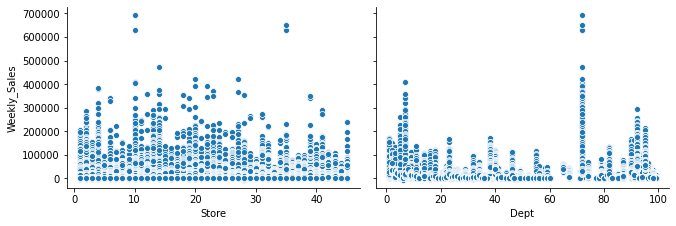

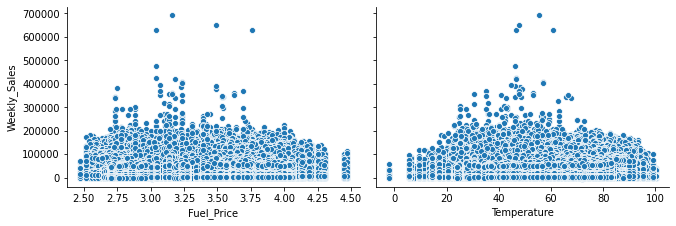

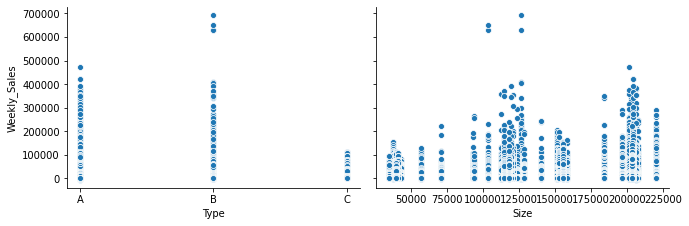

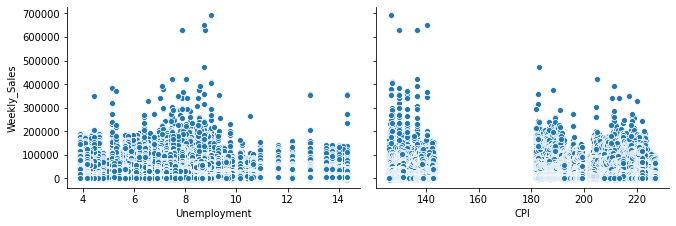

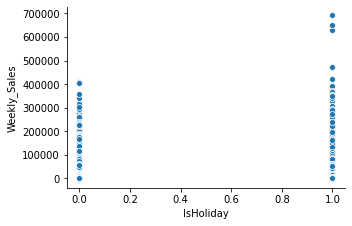

In [40]:
# visualization-weekly sales vs features
sns.pairplot(df ,height=3, aspect=1.5, y_vars=['Weekly_Sales'], 
             x_vars=['Store', 'Dept'])
sns.pairplot(df ,height=3, aspect=1.5, y_vars=['Weekly_Sales'], 
             x_vars=['Fuel_Price', 'Temperature'])
sns.pairplot(df ,height=3, aspect=1.5, y_vars=['Weekly_Sales'], 
             x_vars=['Type', 'Size'])
sns.pairplot(df ,height=3, aspect=1.5, y_vars=['Weekly_Sales'], 
             x_vars=['Unemployment', 'CPI'])
sns.pairplot(df ,height=3, aspect=1.5, y_vars=['Weekly_Sales'], 
             x_vars=['IsHoliday'])

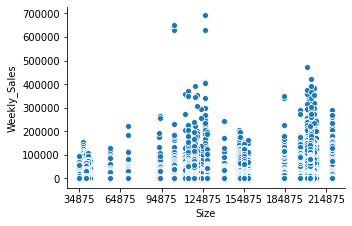

In [41]:
g = sns.pairplot(df ,height=3, aspect=1.5, y_vars=['Weekly_Sales'], 
             x_vars=['Size'])

max_value = df['Size'].max()
min_value = df['Size'].min()
number_of_steps = 30000
l = np.arange(min_value, max_value+1, number_of_steps)
g.set(xticks=l, xticklabels=l)

In [42]:
# weekly sales
df['Weekly_Sales'] = df['Weekly_Sales'].astype(float)
df = df[df['Weekly_Sales']>=0]
df['Weekly_Sales_log'] = np.log1p(df.Weekly_Sales)

# temperature
df['Temperature'] = (df['Temperature'] - 32) * (5/9) # (F to C)

# size
df['Size_log'] = np.log1p(df.Size)
df.drop(['Size'], axis=1, inplace=True)

# time-related features
df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y')
df['week'] = df.Date.dt.week
df['year'] = df.Date.dt.year
df1 = df.copy()
df.drop(['Date'], axis=1, inplace=True)
df['year_week'] =  df['year'].astype(str) + df['week'].astype(str)
df['year_week'] =  df['year_week'].astype(int)
df.loc[df['week']<10, 'year_week'] = df.loc[df['week']<10, 'year'].astype(str) + '0' + df.loc[
    df['week']<10, 'week'].astype(str)
df['year_week'] =  df['year_week'].astype(int)

# data cleaning
df = df.fillna(0)
df['Type'] = df['Type'].factorize()[0]
df.drop(['MarkDown1'], axis=1, inplace=True)
df.drop(['MarkDown2'], axis=1, inplace=True)
df.drop(['MarkDown3'], axis=1, inplace=True)
df.drop(['MarkDown4'], axis=1, inplace=True)
df.drop(['MarkDown5'], axis=1, inplace=True)
df.drop(['year'], axis=1, inplace=True)
df

,Store,Dept,Weekly_Sales,IsHoliday,Type,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales_log,Size_log,week,year_week
0,1,1,24924.50,0,0,5.727778,2.572,211.096358,8.106,10.123647,11.927126,5,201005
1,1,1,46039.49,1,0,3.616667,2.548,211.242170,8.106,10.737277,11.927126,6,201006
2,1,1,41595.55,0,0,4.405556,2.514,211.289143,8.106,10.635773,11.927126,7,201007
3,1,1,19403.54,0,0,8.127778,2.561,211.319643,8.106,9.873262,11.927126,8,201008
4,1,1,21827.90,0,0,8.055556,2.625,211.350143,8.106,9.990990,11.927126,9,201009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,508.37,0,1,18.266667,3.997,192.013558,8.684,6.233175,11.680319,39,201239
421566,45,98,628.10,0,1,18.272222,3.985,192.170412,8.667,6.444290,11.680319,40,201240
421567,45,98,1061.02,0,1,12.483333,4.000,192.327265,8.667,6.967928,11.680319,41,201241
421568,45,98,760.01,0,1,13.594444,3.969,192.330854,8.667,6.634646,11.680319,42,201242


In [43]:
# functions
def data_split(d, t):
    test = d[d.year_week.isin(t)]
    train = d[~d.year_week.isin(t)]
    test.drop(['Weekly_Sales'], axis=1, inplace=True)
    train.drop(['Weekly_Sales'], axis=1, inplace=True)
    X_test = test.drop('Weekly_Sales_log', axis=1)
    y_test = test['Weekly_Sales_log']
    X_train = train.drop('Weekly_Sales_log', axis=1)
    y_train = train['Weekly_Sales_log']
    return X_test, y_test, X_train, y_train

def vis(y_test, y_pred, X_test):
    y = pd.DataFrame(X_test[:], columns=['test', 'pred'])
    y['test'] = np.expm1(y_test)
    y['pred'] = np.expm1(y_pred)
    ax = y.plot(figsize=(10,5),title="Model's Prediction Performance")
    ax.set_xlabel('data row id')
    ax.set_ylabel('weekly sales')
    ax

def accuracy(X_test,y_test, y_pred):
    print('accuracy (R^2):\n', model.score(X_test, y_test)*100, '%')

accuracy (R^2):
 94.93804973458559 %

 out of bag score:
  0.9722716435091473

 feature importances:
  [5.54546768e-02 7.14675333e-01 5.84760420e-04 1.81861405e-02
 8.68919511e-03 6.71070035e-03 1.64434296e-02 1.01447859e-02
 1.28962630e-01 2.81177653e-02 1.20305824e-02]


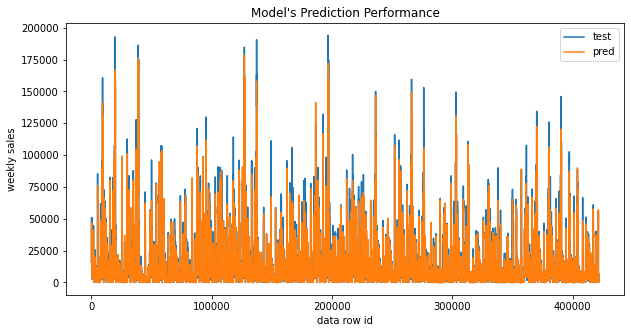

In [44]:
# Random Forest Regressor model
X_test, y_test, X_train, y_train = data_split(df, np.linspace(201230, 201243))
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

Notes:

* criterion='mae' requires a lot more computation -> overloads the CPU

Notes:
* most important features: Dept, Size_log
* least important feature: IsHoliday (!?)

accuracy (R^2):
 94.97992390409112 %

 out of bag score:
  0.972201987101327

 feature importances:
  [0.05543741 0.71465787 0.01559222 0.00876704 0.00677354 0.0162952
 0.00999943 0.13192761 0.02846844 0.01208124]


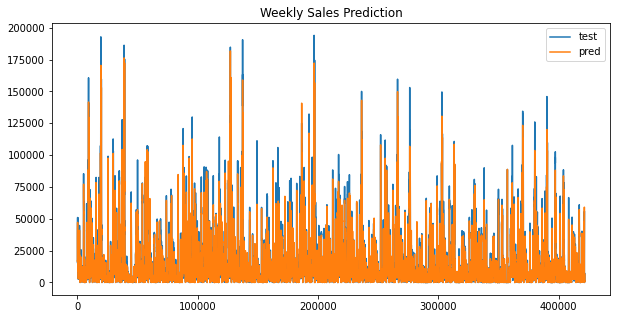

In [38]:
# RF most important features-IsHoliday
X_test.drop(['IsHoliday'], axis=1, inplace=True)
X_train.drop(['IsHoliday'], axis=1, inplace=True)
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

accuracy (R^2):
 94.77008064751404 %

 out of bag score:
  0.9723992942821904

 feature importances:
  [0.05579104 0.71456908 0.0155786  0.00984775 0.01757683 0.01037236
 0.13197796 0.029829   0.01445739]


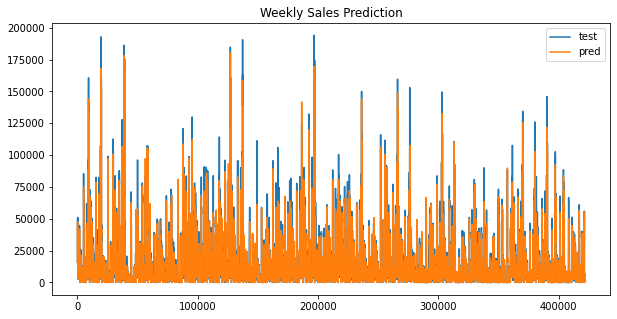

In [39]:
# RF most important features-Fuel_Price
X_test.drop(['Fuel_Price'], axis=1, inplace=True)
X_train.drop(['Fuel_Price'], axis=1, inplace=True)
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

accuracy (R^2):
 94.4317731272383 %

 out of bag score:
  0.9730049963094001

 feature importances:
  [0.05650146 0.7146781  0.01555832 0.01981582 0.01113112 0.13220776
 0.03363211 0.01647531]


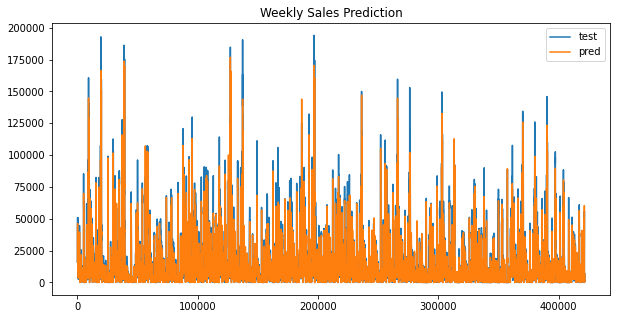

In [40]:
# RF most important features-Temperature
X_test.drop(['Temperature'], axis=1, inplace=True)
X_train.drop(['Temperature'], axis=1, inplace=True)
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

accuracy (R^2):
 94.50865405417103 %

 out of bag score:
  0.9730566064324987

 feature importances:
  [0.05958535 0.71497806 0.01693646 0.02231504 0.13469569 0.03413313
 0.01735628]


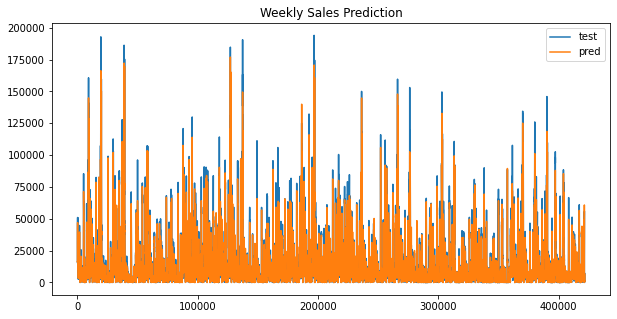

In [41]:
# RF most important features-Unemployment
X_test.drop(['Unemployment'], axis=1, inplace=True)
X_train.drop(['Unemployment'], axis=1, inplace=True)
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

accuracy (R^2):
 95.32231039664745 %

 out of bag score:
  0.970768882778779

 feature importances:
  [0.0591558  0.71463623 0.01690349 0.03440842 0.13536168 0.03953438]


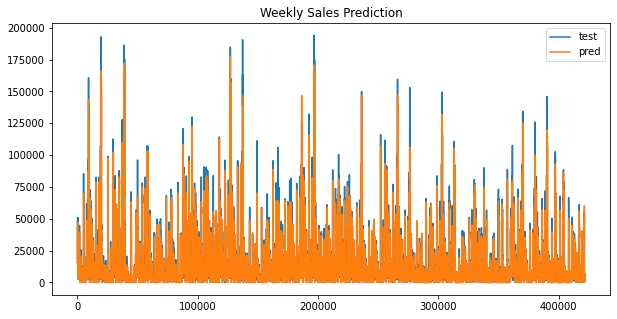

In [42]:
# RF most important features-year_week
X_test.drop(['year_week'], axis=1, inplace=True)
X_train.drop(['year_week'], axis=1, inplace=True)
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

accuracy (R^2):
 93.3055945274145 %

 out of bag score:
  0.940233292180202

 feature importances:
  [0.06618955 0.72460828 0.01710657 0.14319578 0.04889982]


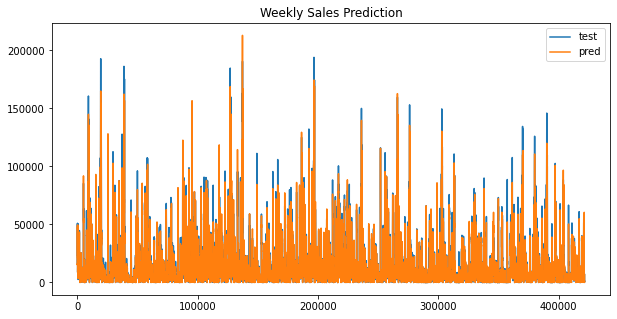

In [43]:
# RF most important features-CPI
X_test.drop(['CPI'], axis=1, inplace=True)
X_train.drop(['CPI'], axis=1, inplace=True)
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

accuracy (R^2):
 93.31546668280005 %

 out of bag score:
  0.9402309114130162

 feature importances:
  [0.06923005 0.72449795 0.15736464 0.04890736]


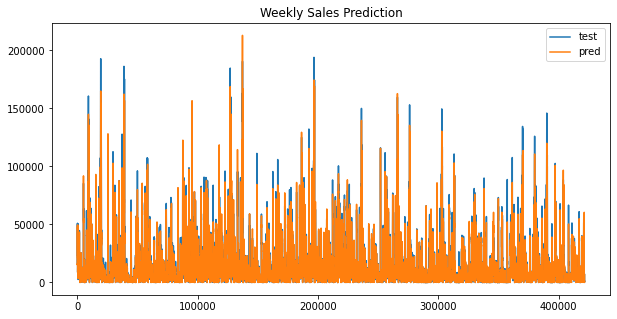

In [44]:
# RF most important features-Type
X_test.drop(['Type'], axis=1, inplace=True)
X_train.drop(['Type'], axis=1, inplace=True)
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

accuracy (R^2):
 92.01029106146737 %

 out of bag score:
  0.9158840842449926

 feature importances:
  [0.0709974  0.76506543 0.16393718]


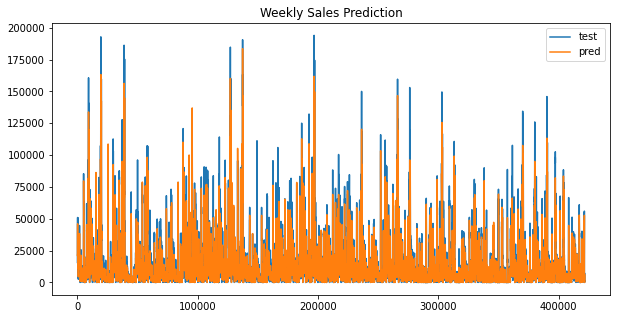

In [45]:
# RF most important features-week
X_test.drop(['week'], axis=1, inplace=True)
X_train.drop(['week'], axis=1, inplace=True)
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

accuracy (R^2):
 91.53893538444908 %

 out of bag score:
  0.9097467004084632

 feature importances:
  [0.77017082 0.22982918]


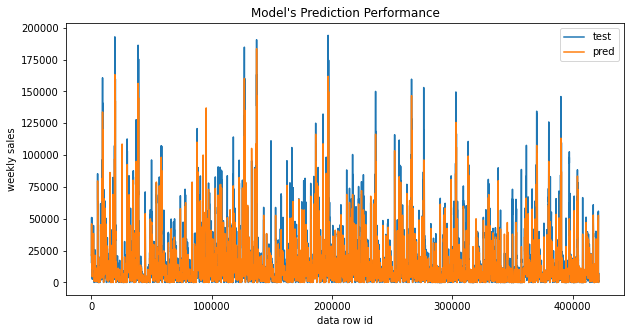

In [28]:
# RF most important features-Store
X_test.drop(['Store'], axis=1, inplace=True)
X_train.drop(['Store'], axis=1, inplace=True)
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

accuracy (R^2):
 50.056922044259075 %

 out of bag score:
  -11.095892527089461

 feature importances:
  [1.]


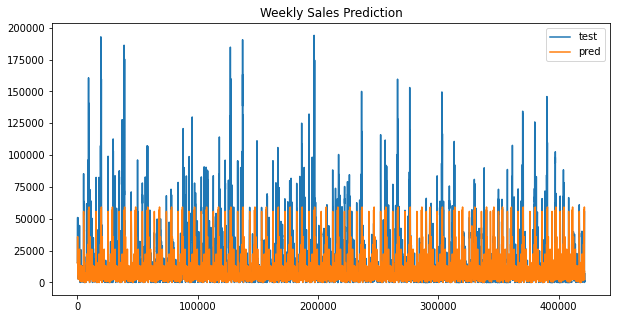

In [47]:
# RF most important features-Size_log
X_test.drop(['Size_log'], axis=1, inplace=True)
X_train.drop(['Size_log'], axis=1, inplace=True)
model = RandomForestRegressor(n_estimators=1, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

In [ ]:
# Store 20
df20 = df.where(df['Store']==20)
df20.dropna(inplace=True)
df20_1 = df20.groupby(by=['year_week'], as_index=False)['Weekly_Sales'].sum()
df20_1['Weekly_Sales_log'] = np.log1p(df20_1.Weekly_Sales)
df20_1

In [13]:
# Store 20
df20_2 = features.where(features['Store']==20)
df20_2.drop(['MarkDown1'], axis=1, inplace=True)
df20_2.drop(['MarkDown2'], axis=1, inplace=True)
df20_2.drop(['MarkDown3'], axis=1, inplace=True)
df20_2.drop(['MarkDown4'], axis=1, inplace=True)
df20_2.drop(['MarkDown5'], axis=1, inplace=True)

df20_2.drop(['Store'], axis=1, inplace=True)
df20_2.dropna(inplace=True)
df20_2['Temperature'] = (df20_2['Temperature'] - 32) * (5/9)

df20_2.Date = pd.to_datetime(df20_2.Date, format='%d/%m/%Y')
df20_2['week'] = df20_2.Date.dt.week
df20_2['year'] = df20_2.Date.dt.year
df20_2.drop(['Date'], axis=1, inplace=True)
df20_2['year_week'] =  df20_2['year'].astype(str) + df20_2['week'].astype(str)
df20_2['year_week'] =  df20_2['year_week'].astype(int)
df20_2.loc[df20_2['week']<10, 'year_week'] = df20_2.loc[df20_2['week']<10, 'year'].astype(str) + '0' + df20_2.loc[df20_2['week']<10, 'week'].astype(str)
df20_2['year_week'] =  df20_2['year_week'].astype(int)

df20_2 = df20_2.reset_index()
df20_2 = df20_2.iloc[:143]
df20_2

,index,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week,year,year_week
0,3458,-3.377778,2.784,204.247194,8.187,0.0,5,2010,201005
1,3459,-5.488889,2.773,204.385747,8.187,1.0,6,2010,201006
2,3460,-3.650000,2.745,204.432100,8.187,0.0,7,2010,201007
3,3461,0.177778,2.754,204.463087,8.187,0.0,8,2010,201008
4,3462,-0.138889,2.777,204.494073,8.187,0.0,9,2010,201009
...,...,...,...,...,...,...,...,...,...
138,3596,14.805556,3.997,215.736716,7.280,0.0,39,2012,201239
139,3597,15.983333,3.985,215.925887,7.293,0.0,40,2012,201240
140,3598,8.444444,4.000,216.115057,7.293,0.0,41,2012,201241
141,3599,13.477778,3.969,216.146470,7.293,0.0,42,2012,201242


In [17]:
# Store 20
df20_3 = pd.merge(df20_1, df20_2)
df20_3['year_week'] = df20_3['year_week'].astype(int)
df20_3.drop(['index'], axis=1, inplace=True)
df20_3.drop(['year'], axis=1, inplace=True)
df20_3

,year_week,Weekly_Sales,Weekly_Sales_log,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,week
0,201005,2401395.47,14.691561,-3.377778,2.784,204.247194,8.187,0.0,5
1,201006,2109107.90,14.561776,-5.488889,2.773,204.385747,8.187,1.0,6
2,201007,2161549.76,14.586336,-3.650000,2.745,204.432100,8.187,0.0,7
3,201008,1898193.95,14.456414,0.177778,2.754,204.463087,8.187,0.0,8
4,201009,2119213.72,14.566556,-0.138889,2.777,204.494073,8.187,0.0,9
...,...,...,...,...,...,...,...,...,...
138,201239,2008388.36,14.512844,14.805556,3.997,215.736716,7.280,0.0,39
139,201240,2246411.89,14.624845,15.983333,3.985,215.925887,7.293,0.0,40
140,201241,2162996.18,14.587005,8.444444,4.000,216.115057,7.293,0.0,41
141,201242,1999363.49,14.508340,13.477778,3.969,216.146470,7.293,0.0,42


accuracy (R^2):
 6.086666934479834 %

 out of bag score:
  0.1282245769983491

 feature importances:
  [0.05741817 0.08449749 0.06911821 0.07477562 0.00882351 0.01236901
 0.69299799]


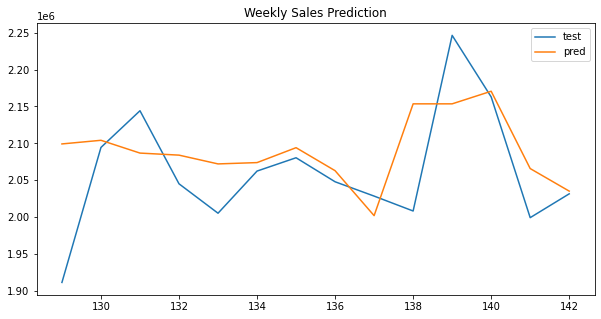

In [31]:
# Random Forest Regressor model Store 20
X_test, y_test, X_train, y_train = data_split(df20_3, np.linspace(201230, 201243))
model = RandomForestRegressor(n_estimators=20, criterion='mse', bootstrap=True, n_jobs=-1,
                              random_state=100, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# performance
accuracy(X_test, y_test, y_pred)
print('\n out of bag score:\n ', model.oob_score_)
print('\n feature importances:\n ', model.feature_importances_)
vis(y_test, y_pred, X_test)

In [34]:
# categorizing the column values
df1 = df.loc[df['Store'].isin([1,2,3])]
df1 = df1.loc[df['Dept'].isin([1,2,3])]
df1.dropna(inplace=True)
df1['Weekly_Sales_log'] = pd.cut(df1['Weekly_Sales_log'], [-0.015, 2.5, 5.25, 8, 10.75, 13.5],
                                 labels=['very low', 'low', 'medium', 'high', 'very high'])
df1['Size_log'] = pd.cut(df1['Size_log'], [10.45, 11.20, 11.70, 12.45], 
                         labels=['small', 'average', 'large'])
df1['Unemployment'] = pd.cut(df1['Unemployment'], [3.5, 6, 8.5, 15], labels=
                             ['low', 'average', 'high'])
df1['CPI'] = pd.cut(df1['CPI'], [125, 145, 180, 230], labels=['low', '', 'high'])
df1['Temperature'] = pd.cut(df1['Temperature'], [-20, 0, 10, 15, 20, 25, 30, 40], labels=
                            ['freezing', 'cold', 'cool', 'normal', 'warm', 'hot', 'very hot'])
df1['Fuel_Price'] = pd.cut(df1['Fuel_Price'], [2.4, 2.8, 4, 5], labels=['low', 'medium', 'high'])
df1.dropna(inplace=True)

# Q (quarters)
df1['Q'] = 4
df1.loc[df1['year_week']<=201242, 'Q'] = 3
df1.loc[df1['year_week']<=201228, 'Q'] = 2
df1.loc[df1['year_week']<=201214, 'Q'] = 1
df1.loc[df1['year_week']<=201200, 'Q'] = 4
df1.loc[df1['year_week']<=201142, 'Q'] = 3
df1.loc[df1['year_week']<=201128, 'Q'] = 2
df1.loc[df1['year_week']<=201114, 'Q'] = 1
df1.loc[df1['year_week']<=201000, 'Q'] = 4
df1.loc[df1['year_week']<=201042, 'Q'] = 3
df1.loc[df1['year_week']<=201028, 'Q'] = 2
df1.loc[df1['year_week']<=201014, 'Q'] = 1

df1.drop('week', axis=1, inplace=True)
df1.drop('year_week', axis=1, inplace=True)
df1.drop('Store', axis=1, inplace=True)
df1.drop('Weekly_Sales', axis=1, inplace=True)
df1.to_csv('d.csv', index=False)
df1.to_csv('dataset_categorized.csv', index=False)
df1

,Dept,IsHoliday,Type,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales_log,Size_log,Q
0,1,0,0,cold,low,high,average,high,large,1
1,1,1,0,cold,low,high,average,high,large,1
2,1,0,0,cold,low,high,average,high,large,1
3,1,0,0,cold,low,high,average,high,large,1
4,1,0,0,cold,low,high,average,high,large,1
...,...,...,...,...,...,...,...,...,...,...
20906,3,0,1,hot,medium,high,average,high,small,3
20907,3,0,1,warm,medium,high,average,high,small,3
20908,3,0,1,warm,medium,high,average,high,small,3
20909,3,0,1,warm,medium,high,average,high,small,3


number of CPIs in [145,180]:  0


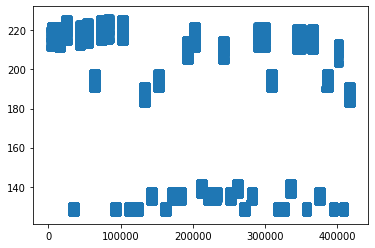

In [17]:
# categorizing CPI
plt.plot(df['CPI'], '.')
print('number of CPIs in [145,180]: ', len(df[(df['CPI']> 145) & (df['CPI']<180)]))

pd.cut() --> values will be NA in the result. Out of bounds values will be NA in the resulting Series or Categorical object.

Categories and their ranges:

1. IsHoliday: 

    0
    
    1


2. Type: 

    A
    
    B
    
    C


3. Temperature:

    freezing:(-20,0]
    
    cold:(0,10]
    
    cool:(10,15]
    
    normal:(15,20]
    
    warm:(20,25]
    
    hot:(25,30]
    
    very hot:(30,40]


4. Fuel_Price:

    low:(2.4,2.8]
    
    medium:(2.8,4]
    
    high:(4,5]


5. CPI:

    low:(125,145]
    
    high:(180,230]


6. Unemployment:

    low:(3.5,6]
    
    average:(6,8.5]
    
    high:(8.5,15]
  
  
7. Weekly_Sales_log:

    very low:(-0.015,2.5]
    
    low:(2.5,5.25]
    
    medium:(5.25,8]
    
    high:(8,10.75]
    
    very high:(10.75,13.5]
    
    
8. Size_log:

    very small:(10.45,10.85]
    
    small:(10.85,11.25]
    
    average:(11.25,11.65]
    
    large:(11.65,12.05]
    
    very large:(12.05,12.45]
    

# Linear Regression

A linear Regression model to predict the sales for store 20

In [16]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings
warnings.filterwarnings('ignore')

accuracy (R^2):
 -759.864352373848 %


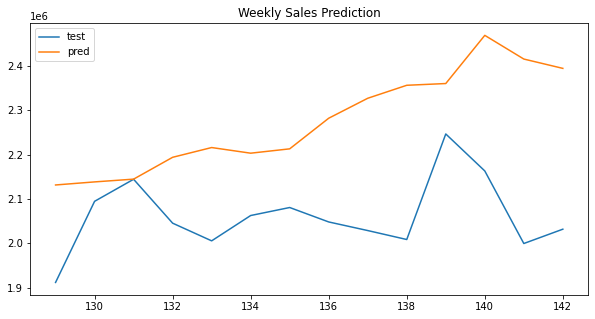

In [35]:
#linear regression Store 20
X_test, y_test, X_train, y_train = data_split(df20_3, np.linspace(201230, 201243))
model = LinearRegression(copy_X=True, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# performance
accuracy(X_test, y_test, y_pred)
vis(y_test, y_pred, X_test)

accuracy (R^2):
 11.562099711020258 %

 coefficients:
  [-1.21495468e-02  1.85250597e-03  5.18903728e-03  5.28490602e-02
 -1.90441458e-03  2.33343359e-02 -7.61869868e-04 -1.65426579e-02
  1.11359026e+00  3.73972419e-03 -3.24703265e-04]


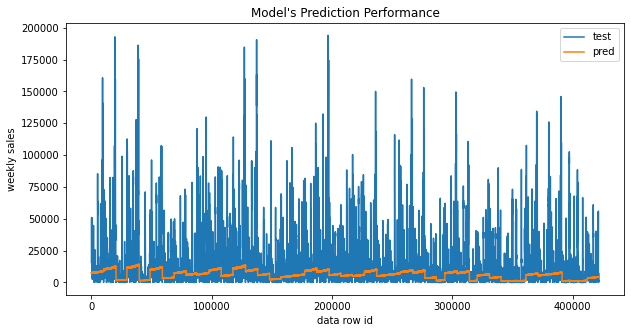

In [23]:
# linear regression-all stores
X_test, y_test, X_train, y_train = data_split(df, np.linspace(201230, 201243))
model = LinearRegression(copy_X=True, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# performance
accuracy(X_test, y_test, y_pred)
vis(y_test, y_pred, X_test)
print('\n coefficients:\n ', model.coef_)

accuracy (R^2):
 11.41572286719362 %

 coefficients:
  [-1.24182109e-02  1.84323322e-03  4.78642678e-02 -7.28338008e-04
  1.11618087e+00  3.55985044e-03]


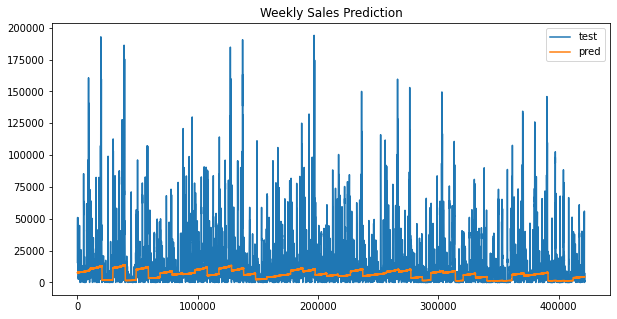

In [72]:
# linear regression-important features
df.drop(['Fuel_Price'], axis=1, inplace=True)
df.drop(['IsHoliday'], axis=1, inplace=True)
df.drop(['Temperature'], axis=1, inplace=True)
df.drop(['Unemployment'], axis=1, inplace=True)
X_test, y_test, X_train, y_train = data_split(df, np.linspace(201230, 201243))
X_train.drop(['year_week'], axis=1, inplace=True)
X_test.drop(['year_week'], axis=1, inplace=True)
model = LinearRegression(copy_X=True, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# performance
accuracy(X_test, y_test, y_pred)
vis(y_test, y_pred, X_test)
print('\n coefficients:\n ', model.coef_)